In [ ]:
model_training_only = False

In [ ]:
import cv2
import os
import time
import torch
from torch import nn, save, load
from torch.optim import Adam
from torch.utils.data import DataLoader
import numpy as np
from sklearn.model_selection import train_test_split

if(not model_training_only):
  import pandas as pd
  from google.colab.patches import cv2_imshow
  import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%run '/content/drive/MyDrive/obj_detect/tools.ipynb'

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
device

'cpu'

In [ ]:
if (not model_training_only):
  imgs_path = f'{drive_path}obj_detect/pics/BCCD Dataset with mask/'
  imgs = os.listdir(imgs_path)

In [ ]:
if (not model_training_only):
  train_path = imgs_path + 'train/'
  train_pics_folder = train_path + 'original/'
  train_mask_folder = train_path + 'mask/'

  test_path = imgs_path + 'test/'
  test_pics_folder = test_path + 'original/'
  test_mask_folder = test_path + 'mask/'

In [ ]:
def accept_img(file_name):
  img_types = ['.png', '.jpg', '.jpeg']
  for i in img_types:
    if (file_name.find(i) != -1):
      return True
  return False

In [ ]:
img_size = 288

In [ ]:
load_it = True
save_it = False
use_test_np = False

In [ ]:
if (not load_it):
  original_images = []
  true_seg = []
  num_of_pics = 0
  start_time = time.time()
  for pic in os.listdir(train_pics_folder):
    if (not accept_img(pic)): continue
    pic_path = train_pics_folder + pic
    mask_path = train_mask_folder + pic

    try:
      img_np = cv2.imread(pic_path)
      img_np = cv2.resize(img_np, (img_size, img_size))
      img_np = cv2.cvtColor(img_np, cv2.COLOR_BGR2RGB)

      mask_np = cv2.imread(mask_path)
      mask_np = cv2.resize(mask_np, (img_size, img_size))
      mask_np = cv2.cvtColor(mask_np, cv2.COLOR_BGR2GRAY)

      original_images.append(img_np)
      true_seg.append(mask_np)

    except:
      continue

    num_of_pics+=1

    if(num_of_pics%10==0):
      end_time = time.time()
      space_='  '
      if(num_of_pics>=100): space_=space_[:len(space_)-1]
      if(num_of_pics>=1000): space_=space_[:len(space_)-1]

      print(f'{num_of_pics} pictures and masks done. {space_}| Time {str(end_time-start_time)[:4]} seconds.')
      start_time = time.time()

    if(save_it):
      if(num_of_pics%100==0):
        np.save(f'{folder_path}train_sets/cell_imgs.npy', original_images)
        np.save(f'{folder_path}train_sets/cell_masks.npy', true_seg)
        print(f'Saved {num_of_pics} images and masks \u2713')
        start_time = time.time()

  if(use_test_np):
    print('Using test images.')
    test_img_path = f'{folder_path}pics/BCCD Dataset with mask/test/'
    img_paths = os.listdir(f'{test_img_path}original/')
    mask_paths = os.listdir(f'{test_img_path}mask/')

    print(f'{len(img_paths)} test images, {len(mask_paths)} test masks.')
    testX_np=[]
    testY_np=[]
    num_test_pics='all'
    if((num_test_pics == 'all')or(num_test_pics == 'All')): end_test = min(len(img_paths), len(mask_paths))
    else: end_test = num_test_pics

    for i in range(end_test):

      img_path = img_paths[i]
      img_full_path = test_img_path+'original/'+img_path
      img = cv2.imread(img_full_path)
      img = cv2.resize(img, (img_size, img_size))
      original_images.append(img)

      mask_path = mask_paths[i]

      if((img_path.find('.jpg')!=-1)or(img_path.find('.jpeg')!=-1)): mask_path = img_path[:img_path.find('.j')] + '.png'
      else: mask_path = img_path

      mask_full_path = test_img_path+'mask/'+mask_path
      mask = cv2.imread(mask_full_path)
      mask = cv2.resize(mask, (img_size, img_size))
      mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
      true_seg.append(mask)

    print(f'{original_images.shape[0]} test images and {true_seg.shape[0]} test masks being used.')

  original_images = np.array(original_images)
  true_seg = np.array(true_seg)

  if(save_it):
    np.save(f'{folder_path}train_sets/cell_imgs.npy', original_images)
    np.save(f'{folder_path}train_sets/cell_masks.npy', true_seg)

else:
  original_images = np.load(f'{folder_path}train_sets/cell_imgs.npy')
  true_seg = np.load(f'{folder_path}train_sets/cell_masks.npy')
  print(f'Successfully loaded train set of {original_images.shape[0]} images and {true_seg.shape[0]} masks.')


Successfully loaded train set of 1222 images and 1222 masks.


In [ ]:
if(use_test_np):

  test_img_path = f'{folder_path}pics/BCCD Dataset with mask/test/'
  img_paths = os.listdir(f'{test_img_path}original/')
  mask_paths = os.listdir(f'{test_img_path}mask/')

  print(f'{len(img_paths)} test images, {len(mask_paths)} test masks.')
  testX_np=[]
  testY_np=[]

  num_test_pics = 'all'
  if((num_test_pics == 'all')or(num_test_pics == 'All')): end_test = min(len(img_paths), len(mask_paths))
  else: end_test = num_test_pics

  for i in range(end_test):
  # if(True):
    # i=2
    img_path = img_paths[i]
    img_full_path = test_img_path+'original/'+img_path
    img = cv2.imread(img_full_path)
    img = cv2.resize(img, (img_size, img_size))
    testX_np.append(img)

    mask_path = mask_paths[i]

    if((img_path.find('.jpg')!=-1)or(img_path.find('.jpeg')!=-1)): mask_path = img_path[:img_path.find('.j')] + '.png'
    else: mask_path = img_path

    mask_full_path = test_img_path+'mask/'+mask_path
    mask = cv2.imread(mask_full_path)
    mask = cv2.resize(mask, (img_size, img_size))
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    testY_np.append(mask)

  testX_np = np.array(testX_np)
  testY_np = np.array(testY_np)

  print(f'{true_seg.shape} + {testY_np.shape}')
  print(f'{original_images.shape} + {testX_np.shape}')

  original_images = np.concatenate((original_images, testX_np), axis=0)
  true_seg = np.concatenate((true_seg, testY_np), axis=0)

  print(f'{testX_np.shape[0]} test images and {testY_np.shape[0]} test masks loaded as numpy arrays.')
  print(f'{original_images.shape[0]} test images and {true_seg.shape[0]} test masks loaded as numpy arrays.')

In [ ]:
  # save_it=True
  # if(save_it):
  #   np.save(f'{folder_path}train_sets/cell_imgs.npy', original_images)
  #   np.save(f'{folder_path}train_sets/cell_masks.npy', true_seg)

In [ ]:
original_images = np.array(original_images)
true_seg = np.array(true_seg)

In [ ]:
print(original_images.shape)
print(true_seg.shape)

(1222, 288, 288, 3)
(1222, 288, 288)


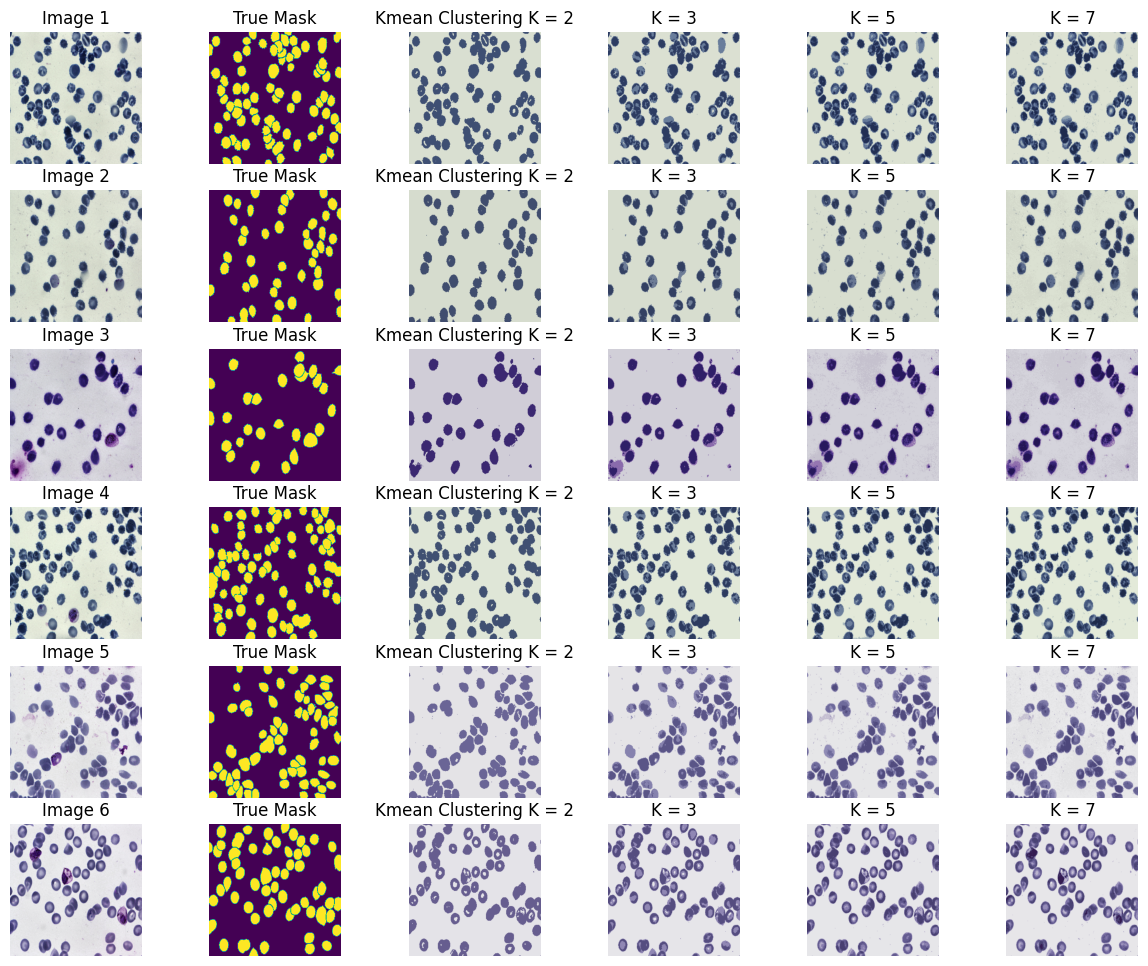

In [ ]:
graph_kmeans_before = True
if(graph_kmeans_before):
  num_rows = 6
  num_cols = 6
  fig, axes = plt.subplots(num_rows, num_cols, figsize=(int(2.5*num_cols), 2*num_rows))

  # Flatten the axes array to make it easier to iterate
  axes = axes.flatten()
  # Iterate through the data and create subplots

  for i in range(num_rows):
      pic_num = i*5

      # Plot image in the first column

      axes[i * num_cols].imshow(original_images[pic_num])
      axes[i * num_cols].set_title(f'Image {i+1}')
      axes[i * num_cols].axis('off')

      # Plot true mask in the third column

      true_mask = true_seg[pic_num]

      axes[i * num_cols + 1].imshow(true_mask.astype(int))
      axes[i * num_cols + 1].set_title('True Mask')
      axes[i * num_cols + 1].axis('off')

      # Plot image in the first column
      ogimg = original_images[pic_num]
      kmean2 = kmeans_np(ogimg, 2)

      axes[i * num_cols + 2].imshow(kmean2)
      axes[i * num_cols + 2].set_title(f'Kmean Clustering K = 2')
      axes[i * num_cols + 2].axis('off')

      # Plot image in the first column
      ogimg = original_images[pic_num]
      kmean3 = kmeans_np(ogimg, 3)

      axes[i * num_cols + 3].imshow(kmean3)
      axes[i * num_cols + 3].set_title(f'K = 3')
      axes[i * num_cols + 3].axis('off')

      kmean5 = kmeans_np(ogimg, 5)

      axes[i * num_cols + 4].imshow(kmean5)
      axes[i * num_cols + 4].set_title(f'K = 5')
      axes[i * num_cols + 4].axis('off')

      kmean7 = kmeans_np(ogimg, 7)

      axes[i * num_cols + 5].imshow(kmean7)
      axes[i * num_cols + 5].set_title(f'K = 7')
      axes[i * num_cols + 5].axis('off')


In [ ]:
torchX = torch.tensor(original_images.transpose(0, 3, 1, 2), dtype=torch.float32)
torchY = torch.tensor(true_seg, dtype=torch.float32)

In [ ]:
torchX = torchX.to(device)
torchY = torchY.to(device)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(torchX, torchY, test_size=0.15, random_state=1245)

In [ ]:
print(f"Train sizes | X {np.array(x_train.to('cpu')).shape} | Y {np.array(y_train.to('cpu')).shape} |")
print(f"Test sizes | X {np.array(x_test.to('cpu')).shape} | Y {np.array(y_test.to('cpu')).shape} |")

Train sizes | X (977, 3, 288, 288) | Y (977, 288, 288) |
Test sizes | X (245, 3, 288, 288) | Y (245, 288, 288) |


In [ ]:
np.array(x_train.to('cpu')).shape

(977, 3, 288, 288)

In [ ]:
# load train and test splits as np arrays so I don't test on train set if I just load the whole dataset again and make new train test splits at random
load_train_test_splits = True

In [ ]:
if (not load_train_test_splits):
  np.save(f'{folder_path}train_sets/train_cell_imgs.npy', np.array(x_train.to('cpu')))
  np.save(f'{folder_path}train_sets/train_cell_masks.npy', np.array(y_train.to('cpu')))

  np.save(f'{folder_path}train_sets/test_cell_imgs.npy', np.array(x_test.to('cpu')))
  np.save(f'{folder_path}train_sets/test_cell_masks.npy', np.array(y_test.to('cpu')))
else:
  x_train = np.load(f'{folder_path}train_sets/train_cell_imgs.npy')
  x_train = torch.tensor(x_train, dtype = torch.float32).to(device)
  y_train = np.load(f'{folder_path}train_sets/train_cell_masks.npy')
  y_train = torch.tensor(y_train, dtype = torch.float32).to(device)

  x_test = np.load(f'{folder_path}train_sets/test_cell_imgs.npy')
  x_test = torch.tensor(x_test, dtype = torch.float32).to(device)
  y_test = np.load(f'{folder_path}train_sets/test_cell_masks.npy')
  y_test = torch.tensor(y_test, dtype = torch.float32).to(device)

  print(f"Train sizes | X {np.array(x_train.to('cpu')).shape} | Y {np.array(y_train.to('cpu')).shape} |")
  print(f"Test sizes  | X {np.array(x_test.to('cpu')).shape} | Y {np.array(y_test.to('cpu')).shape} |")

Train sizes | X (977, 3, 288, 288) | Y (977, 288, 288) |
Test sizes  | X (245, 3, 288, 288) | Y (245, 288, 288) |


In [ ]:
in_c = 3
num_classes = 1
h_c1 = 84
h_c2 = 128

In [ ]:
class image_seg_UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.step_down_1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=(3,3), padding = 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=(3,3), padding = 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2,2), stride=2)
        )

        self.step_down_2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=(3,3), padding = 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=(3,3), padding = 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2,2), stride=2)
        )

        self.step_down_3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=(3,3), padding = 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=(3,3), padding = 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2,2), stride=2)
        )

        self.step_down_4 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=(3,3), padding = 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=(3,3), padding = 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(3,3), stride=3)
        )

        self.step_up_4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=(3,3), padding = 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=(3,3), padding = 1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 128, kernel_size=(3,3), stride=3)
        )

        new_channels = 128+128

        self.step_up_3 = nn.Sequential(
            nn.Conv2d(new_channels, new_channels, kernel_size=(3,3), padding = 1),
            nn.ReLU(inplace=True),

            nn.Conv2d(new_channels, 128, kernel_size=(3,3), padding = 1),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 128, kernel_size=(2,2), stride = 2),
            nn.ReLU(inplace=True),
        )

        new_channels = 128+64

        self.step_up_2 = nn.Sequential(
            nn.Conv2d(new_channels, new_channels, kernel_size=(3,3), padding = 1),
            nn.ReLU(inplace=True),

            nn.Conv2d(new_channels, 64, kernel_size=(3,3), padding = 1),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 64, kernel_size=(2,2), stride = 2),
            nn.ReLU(inplace=True),
        )

        new_channels = 64+64

        self.step_up_1 = nn.Sequential(
            nn.Conv2d(new_channels, 64, kernel_size=(3,3), padding = 1),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 64, kernel_size=(3,3), padding = 1),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 64, kernel_size=(2,2), stride = 2),
            nn.ReLU(inplace=True),
        )

        self.class_predictions_block = nn.Sequential(
            nn.Conv2d(64, 16, kernel_size = (3,3), padding = 1),
            nn.Conv2d(16, 1, kernel_size = (3,3), padding = 1)
        )


    def forward(self, x):

        output = self.step_down_1(x)
        skip_1 = output

        output = self.step_down_2(output)
        skip_2 = output

        output = self.step_down_3(output)
        skip_3 = output

        output = self.step_down_4(output)

        output = self.step_up_4(output)
        output = torch.cat((output, skip_3), dim=1)

        output = self.step_up_3(output)
        output = torch.cat((output, skip_2), dim=1)

        output = self.step_up_2(output)
        output = torch.cat((output, skip_1), dim=1)

        output = self.step_up_1(output)

        output = self.class_predictions_block(output)

        return output

In [ ]:
#create instance of CNN Image Classifier
obj_detect = image_seg_UNet(in_c, num_classes).to(device)

#optimizer, lr = learning rate
opt = Adam(obj_detect.parameters(), lr=1e-3)

#loss function
loss_fn = nn.MSELoss()

In [ ]:
# for p in obj_detect.parameters():
#   print(p.device)

In [ ]:
preds = obj_detect(x_train[:4])
preds = preds.to('cpu')
np_preds = preds.detach().numpy()
print(np_preds.shape)

(4, 1, 288, 288)


In [ ]:
# np_preds = np_preds.transpose(0, 2, 3, 1)
# cv2_imshow(np_preds[2])

In [ ]:
num_epochs = 20
epoch_print_interval = 1

In [ ]:
#set to true only when it is train time
train_time = True
updateModel = False

In [ ]:
training_length = 1.0

In [ ]:
y_test.shape

torch.Size([245, 288, 288])

In [ ]:
# Training flow
if (train_time):

    train = []
    if((training_length == 'all')or(training_length == 'All')): training_length = int(len(x_train))
    elif(training_length <= 1): training_length = int(training_length * len(x_train))

    print(f'Training Length {training_length}.')

    for i in range(training_length):
        train.append((x_train[i], y_train[i]))

    trainloader = DataLoader(train, 32)

    start_time = time.time()
    last_loss = 'skip'
    for epoch in range(1, num_epochs+1):
        for batch in trainloader:
            x,y = batch
            x, y = x.to(device), y.to(device)
            yhat = obj_detect(x).squeeze()
            # print(yhat.shape, y.shape)

            loss = loss_fn(yhat, y)

            # backpropogation
            opt.zero_grad()
            loss.backward()
            opt.step()

        # print loss for epoch every so often
        if (epoch%epoch_print_interval==0):
          end_time = time.time()
          if (last_loss == 'skip'):
            last_loss = float(loss.item())
            print_last_loss = ''
          else:
            current_loss = float(loss.item())
            sign = ''
            if(current_loss>last_loss): sign = '+'
            proportion = ((current_loss-last_loss)/last_loss)
            if (abs(proportion) < 0.0001):
              print_last_loss = ' no change'
            else:
              print_last_loss = f' | Loss Change {sign}{str(proportion*100)[:5]}%'

            last_loss = current_loss

          print(f"Epoch {epoch} loss is {str(loss.item())[:8]}{print_last_loss} | Time {str(end_time-start_time)[:4]} seconds.")
          start_time = time.time()

    if (updateModel):
        #save trained model into 'model_state.pt'
        with open(f'{drive_path}obj_detect/saved_models/cell_segmentation_model_trained.pt', 'wb') as f:
            save(obj_detect.state_dict(), f)

        print(f'Successfully updated model.')

# ________________________________________________________________________________________________________________________________________________________________
else:
  obj_detect = image_seg_UNet(in_c, num_classes).to(device)
  with open(f'{drive_path}obj_detect/saved_models/cell_segmentation_model_trained.pt', 'rb') as f:
        if(device == 'cpu'):
          obj_detect.load_state_dict(load(f, map_location=torch.device('cpu')))
          print(f'Successfully loaded model to {device}.')
        else:
          obj_detect.load_state_dict(load(f))
          print(f'Successfully loaded model to {device}.')


Training Length 977.
Epoch 1 loss is 873.7984 | Time 5.37 seconds.
Epoch 2 loss is 863.8135 | Loss Change -1.14% | Time 5.36 seconds.
Epoch 3 loss is 842.3485 | Loss Change -2.48% | Time 5.36 seconds.
Epoch 4 loss is 837.7844 | Loss Change -0.54% | Time 5.36 seconds.
Epoch 5 loss is 828.8427 | Loss Change -1.06% | Time 5.36 seconds.
Epoch 6 loss is 807.3156 | Loss Change -2.59% | Time 5.36 seconds.
Epoch 7 loss is 809.5941 | Loss Change +0.282% | Time 5.36 seconds.
Epoch 8 loss is 912.6143 | Loss Change +12.72% | Time 5.35 seconds.
Epoch 9 loss is 827.1607 | Loss Change -9.36% | Time 5.35 seconds.
Epoch 10 loss is 807.3587 | Loss Change -2.39% | Time 5.36 seconds.
Epoch 11 loss is 800.1167 | Loss Change -0.89% | Time 5.36 seconds.
Epoch 12 loss is 786.3004 | Loss Change -1.72% | Time 5.36 seconds.
Epoch 13 loss is 795.9367 | Loss Change +1.225% | Time 5.36 seconds.
Epoch 14 loss is 809.6893 | Loss Change +1.727% | Time 5.36 seconds.
Epoch 15 loss is 785.6605 | Loss Change -2.96% | Time

In [ ]:
# #save trained model into 'model_state.pt'
# with open(f'{drive_path}obj_detect/saved_models/cell_segmentation_model_trained.pt', 'wb') as f:
#     save(obj_detect.state_dict(), f)
# print('Successfully saved model.')

Successfully saved model.


In [ ]:
test_size = 100

In [ ]:
predictions = obj_detect(x_test[:test_size]).to('cpu')
predictions = predictions.squeeze()
np_preds = predictions.detach().numpy()
testY_np = np.array(y_test.to('cpu'))
print(np_preds.shape)

OutOfMemoryError: ignored

In [ ]:
graph = True

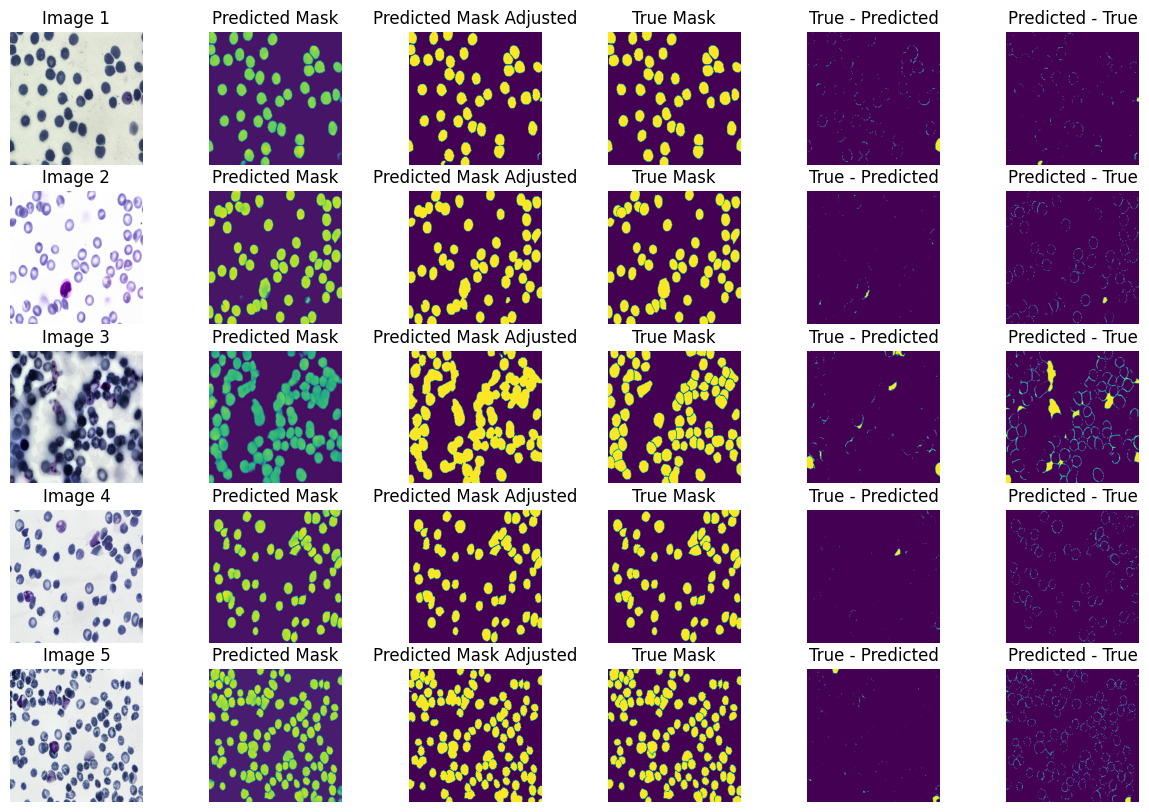

In [ ]:
if (graph):
  num_rows = 5
  num_cols = 6
  fig, axes = plt.subplots(num_rows, num_cols, figsize=(int(2.5*num_cols), 2*num_rows))

  # Flatten the axes array to make it easier to iterate
  axes = axes.flatten()
  test_np = np.array(x_test.to('cpu')).transpose(0, 2, 3, 1).astype(int)
  # Iterate through the data and create subplots
  accuracy = []
  miss = []

  for i in range(num_rows):
      pic_num = i*2

      # Plot image in the first column
      axes[i * num_cols].imshow(test_np[pic_num])
      axes[i * num_cols].set_title(f'Image {i+1}')
      axes[i * num_cols].axis('off')

      # Plot predicted mask in the second column
      t1 = np_preds[pic_num].astype(int).copy()

      axes[i * num_cols + 1].imshow(t1)
      axes[i * num_cols + 1].set_title('Predicted Mask')
      axes[i * num_cols + 1].axis('off')

      # threshholds for mask
      t1[t1 < 100] = 0
      t1[t1 > 0] = 255

      t1_total = t1.copy()
      t1_total[t1_total > 0] = 1
      pred_sum = np.sum(t1_total)

      axes[i * num_cols + 2].imshow(t1)
      axes[i * num_cols + 2].set_title('Predicted Mask Adjusted')
      axes[i * num_cols + 2].axis('off')

      # Plot true mask in the third column

      true_mask = testY_np[pic_num]
      # print(true_mask.shape)
      # true_mask = cv2.cvtColor(true_mask, cv2.COLOR_BGR2GRAY)

      sum_mask = true_mask.copy()
      sum_mask[sum_mask > 0] = 1

      total = np.sum(sum_mask)

      axes[i * num_cols + 3].imshow(true_mask.astype(int))
      axes[i * num_cols + 3].set_title('True Mask')
      axes[i * num_cols + 3].axis('off')


      # Plot true mask in the third column

      t_p = true_mask.squeeze() - t1.squeeze()

      t_p[t_p < 0] = 0
      t_p[t_p > 150] = 255

      t_p_sum = t_p.copy()
      t_p_sum[t_p_sum > 0] = 1
      correct = np.sum(t_p_sum)

      acc = 1 - (correct/total)

      axes[i * num_cols + 4].imshow(t_p.astype(int))
      axes[i * num_cols + 4].set_title('True - Predicted')
      axes[i * num_cols + 4].axis('off')

      # Plot true mask in the third column

      p_t = t1.squeeze() - true_mask.squeeze()

      p_t[p_t < 0] = 0
      p_t[p_t > 150] = 255

      p_t_sum = p_t.copy()
      p_t_sum[p_t_sum > 0] = 1

      missed = np.sum(p_t_sum)

      miss_proportion = missed/pred_sum

      accuracy.append(acc)
      miss.append(miss_proportion)

      axes[i * num_cols + 5].imshow(p_t.astype(int))
      axes[i * num_cols + 5].set_title('Predicted - True')
      axes[i * num_cols + 5].axis('off')

In [ ]:
for i in range(len(miss)):
  print(f'| Image {i+1} | Accuracy is {str(accuracy[i]*100)[:4]}% | Incorrect Classification Rate is {str(miss[i]*100)[:4]}% |')

| Image 1 | Accuracy is 96.6% | Incorrect Classification Rate is 4.42% |
| Image 2 | Accuracy is 97.0% | Incorrect Classification Rate is 7.05% |
| Image 3 | Accuracy is 98.3% | Incorrect Classification Rate is 20.0% |
| Image 4 | Accuracy is 98.4% | Incorrect Classification Rate is 7.72% |
| Image 5 | Accuracy is 98.0% | Incorrect Classification Rate is 9.06% |


In [ ]:
import statistics as stat

In [ ]:
test_np = np.array(x_test.to('cpu')).transpose(0, 2, 3, 1).astype(int)
# Iterate through the data and create subplots
accuracy = []
miss = []

for i in range(len(np_preds)):
    pic_num = i

    t1 = np_preds[pic_num].astype(int).copy()

    # threshholds for mask
    t1[t1 < 100] = 0
    t1[t1 > 0] = 255

    t1_total = t1.copy()
    t1_total[t1_total > 0] = 1
    pred_sum = np.sum(t1_total)

    true_mask = testY_np[pic_num]
    # true_mask = cv2.cvtColor(true_mask, cv2.COLOR_BGR2GRAY)

    sum_mask = true_mask.copy()
    sum_mask[sum_mask > 0] = 1

    total = np.sum(sum_mask)

    t_p = true_mask.squeeze() - t1.squeeze()

    t_p[t_p < 0] = 0
    t_p[t_p > 150] = 255

    t_p_sum = t_p.copy()
    t_p_sum[t_p_sum > 0] = 1
    incorrect = np.sum(t_p_sum)

    # accuracy for this test sample
    acc = 1 - (incorrect/total)

    p_t = t1.squeeze() - true_mask.squeeze()

    p_t[p_t < 0] = 0
    p_t[p_t > 150] = 255

    p_t_sum = p_t.copy()
    p_t_sum[p_t_sum > 0] = 1

    missed = np.sum(p_t_sum)

    # proportion of predicted segmentation that is wrong
    miss_proportion = missed/pred_sum

    accuracy.append(acc)
    miss.append(miss_proportion)

In [ ]:
average_accuracy = str(stat.mean(accuracy)*100)[:4]
average_miss = str(stat.mean(miss)*100)[:4]
print(f'| Average Test Accuracy {(average_accuracy)}% | Average Inaccurate Classification Rate {average_miss}% |')

| Average Accuracy 96.0% | Average Inaccurate Classification Rate 6.82% |


In [ ]:
test_metrics_df = pd.DataFrame([], [], ['Accuracy', 'Inaccurate Classification Rate'])
test_metrics_df['Accuracy'] = accuracy
test_metrics_df['Inaccurate Classification Rate'] = miss
test_metrics_df.head(5)

,Accuracy,Inaccurate Classification Rate
0,0.948955,0.034688
1,0.984137,0.065349
2,0.986137,0.064199
3,0.989541,0.122312
4,0.950005,0.177186


Text(0, 0.5, 'Proportion of Predicted Segmentation that is wrong ')

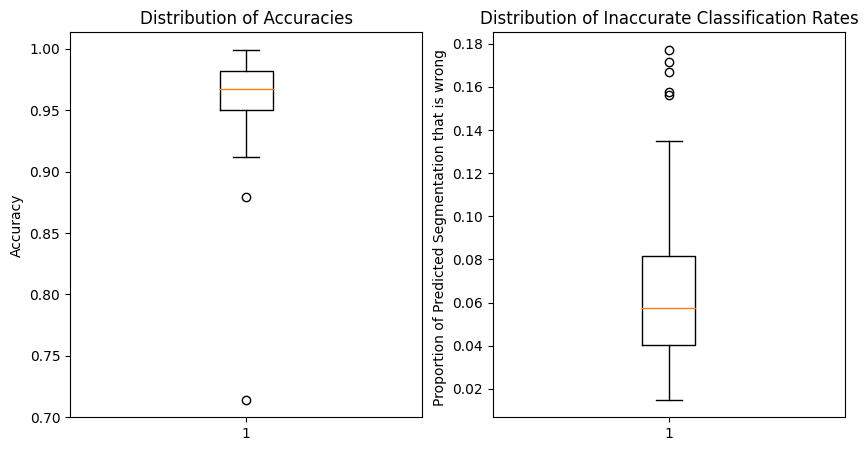

In [ ]:
# plt.figure(figsize=(2, 4))
# plt.boxplot(test_metrics_df['Accuracy'])
# plt.title('Distribution of Accuracy from Segmentation among Test Samples')

fig, sections = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# Plot the first graph in the left subplot
sections[0].boxplot(test_metrics_df['Accuracy'])
sections[0].set_title('Distribution of Accuracies')
sections[0].set_ylabel('Accuracy')

# Plot the second graph in the right subplot
sections[1].boxplot(test_metrics_df['Inaccurate Classification Rate'])
sections[1].set_title('Distribution of Inaccurate Classification Rates')
sections[1].set_ylabel('Proportion of Predicted Segmentation that is wrong ')

In [ ]:
test_metrics_df[test_metrics_df['Accuracy'] < 0.7]

,Accuracy,Inaccurate Classification Rate


In [ ]:
pic_indices = [58]

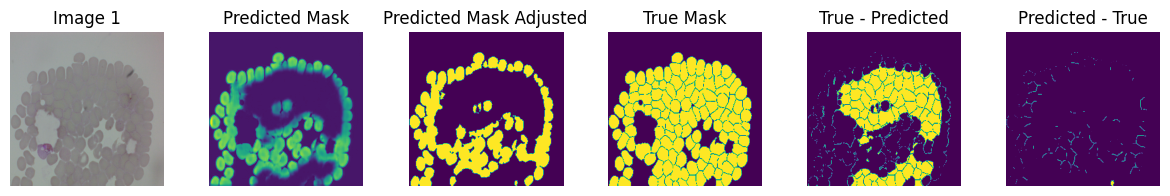

In [ ]:
if (graph):
  num_rows = 1
  num_cols = 6
  fig, axes = plt.subplots(num_rows, num_cols, figsize=(int(2.5*num_cols), 2*num_rows))

  # Flatten the axes array to make it easier to iterate
  axes = axes.flatten()
  test_np = np.array(x_test.to('cpu')).transpose(0, 2, 3, 1).astype(int)

  for i in range(num_rows):
      pic_num = pic_indices[i]

      # Plot image in the first column
      axes[i * num_cols].imshow(test_np[pic_num])
      axes[i * num_cols].set_title(f'Image {i+1}')
      axes[i * num_cols].axis('off')

      # Plot predicted mask in the second column
      t1 = np_preds[pic_num].astype(int).copy()

      axes[i * num_cols + 1].imshow(t1)
      axes[i * num_cols + 1].set_title('Predicted Mask')
      axes[i * num_cols + 1].axis('off')

      # threshholds for mask
      t1[t1 < 100] = 0
      t1[t1 > 0] = 255

      t1_total = t1.copy()
      t1_total[t1_total > 0] = 1
      pred_sum = np.sum(t1_total)

      axes[i * num_cols + 2].imshow(t1)
      axes[i * num_cols + 2].set_title('Predicted Mask Adjusted')
      axes[i * num_cols + 2].axis('off')

      # Plot true mask in the third column

      true_mask = testY_np[pic_num]

      axes[i * num_cols + 3].imshow(true_mask.astype(int))
      axes[i * num_cols + 3].set_title('True Mask')
      axes[i * num_cols + 3].axis('off')


      # Plot true mask in the third column

      t_p = true_mask.squeeze() - t1.squeeze()

      t_p[t_p < 0] = 0
      t_p[t_p > 150] = 255

      axes[i * num_cols + 4].imshow(t_p.astype(int))
      axes[i * num_cols + 4].set_title('True - Predicted')
      axes[i * num_cols + 4].axis('off')

      # Plot true mask in the third column

      p_t = t1.squeeze() - true_mask.squeeze()

      p_t[p_t < 0] = 0
      p_t[p_t > 150] = 255

      axes[i * num_cols + 5].imshow(p_t.astype(int))
      axes[i * num_cols + 5].set_title('Predicted - True')
      axes[i * num_cols + 5].axis('off')